# references
1. https://www.kaggle.com/columbia2131/device-eda-interpolate-by-removing-device-en-ja

# Load Libraries

In [1]:
import numpy as np
import pandas as pd
from glob import glob
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pathlib import Path
import plotly.express as px

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
notebookName = 'Baseline'
PATH = Path(f"./models/{notebookName}")

In [4]:
if os.path.isdir(PATH):
    dir_list = os.listdir(PATH)
    num_files = 0
    while True:
        if os.path.isfile(str(PATH / f"{num_files}")):
            print(num_files)
            num_files += 1
        else:
            break
else:
    os.mkdir(PATH)
    num_files = 0

0
1
2
3


In [5]:
num_files

4

In [57]:
RANDOM_STATE = 1990
lr = 0.001
batch_size = 256
EPOCH_NUM = 1000

torch.manual_seed(RANDOM_STATE)

experience_name = f"{num_files}"
checkpoint_name = "check_point"
model_name = str("model - " + experience_name)
param_name = str("param - " + experience_name)
result_name = str("result - " + experience_name)

dummy_path = str(PATH / f"{num_files}")
checkpoint_path = str(PATH / f"{checkpoint_name}.pth")
model_path = str(PATH / f"{model_name}.pth")
param_path = str(PATH / f"{param_name}.pth")
result_path = str(PATH / f"{result_name}.csv")
model_path, param_path, result_path

('models\\Baseline\\model - 4.pth',
 'models\\Baseline\\param - 4.pth',
 'models\\Baseline\\result - 4.csv')

# Useful Functions

In [7]:
def calc_haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
    
    c = 2 * np.arcsin(a ** 0.5)
    dist = 6_367_000 * c
    return dist

In [8]:
def check_score(input_df: pd.DataFrame) -> pd.DataFrame:
    output_df = input_df.copy()
    
    output_df['meter'] = input_df.apply(
        lambda r: calc_haversine(
            r.latDeg, r.lngDeg, r.t_latDeg, r.t_lngDeg
        ),
        axis=1
    )

    meter_score = output_df['meter'].mean()
    print(f'error meter: {meter_score}')

    scores = []
    for phone in output_df['phone'].unique():
        _index = output_df['phone']==phone
        p_50 = np.percentile(output_df.loc[_index, 'meter'], 50)
        p_95 = np.percentile(output_df.loc[_index, 'meter'], 95)
        scores.append(p_50)
        scores.append(p_95)

    score = sum(scores) / len(scores)
    print(f'score: {score}')
    
    return output_df, meter_score , score

In [9]:
def check_score_np(predict:torch.Tensor, target:torch.Tensor):
    m = []
    predict = predict.detach().numpy()
    target = target.detach().numpy()
    for i in range(predict.shape[0]):
        temp = calc_haversine(predict[i,0], predict[i,1], target[i,0], target[i,1])
        m.append(temp)
    
    m = np.array(m)
    score = (np.percentile(m, 50) + np.percentile(m, 95))/2
    
    return score

# Load Datasets

In [10]:
data_dir = Path("../input/google-smartphone-decimeter-challenge")
df_train = pd.read_pickle(str(data_dir / "gsdc_train.pkl.gzip"))

In [11]:
# check score
df_train, default_loss, default_meas = check_score(df_train)

error meter: 3.84684837499064
score: 5.2879706490841585


# Feature Engineering
## Simple view, what is in data frame.

In [12]:
print(df_train.shape)
df_train.head()

(131342, 111)


,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM,phone,utcTimeMillis_x,elapsedRealtimeNanos_x,UncalGyroXRadPerSec,...,ySatVelMps,zSatVelMps,satClkBiasM,satClkDriftMps,rawPrM,rawPrUncM,isrbM,ionoDelayM,tropoDelayM,meter
0,2020-05-14-US-MTV-1,Pixel4,1273529463442,37.423575,-122.094091,-34.06,2020-05-14-US-MTV-1_Pixel4,1.589494e+12,1.965654e+13,-0.000502,...,156.040,3559.757,-468.084,0.001,2.379498e+07,11.992,1134.758,10.866,16.647,3.586842
1,2020-05-14-US-MTV-1,Pixel4,1273529464442,37.423578,-122.094101,-33.29,2020-05-14-US-MTV-1_Pixel4,1.589494e+12,1.965754e+13,-0.003537,...,411.162,-3013.649,65954.431,-0.002,2.592442e+07,3.897,-222.675,7.111,5.174,2.745901
2,2020-05-14-US-MTV-1,Pixel4,1273529465442,37.423573,-122.094111,-30.99,2020-05-14-US-MTV-1_Pixel4,1.589494e+12,1.965854e+13,0.002028,...,-2776.605,-434.445,1223.261,0.000,2.131445e+07,1.499,0.000,4.777,3.371,1.888409
3,2020-05-14-US-MTV-1,Pixel4,1273529466442,37.423583,-122.094121,-32.83,2020-05-14-US-MTV-1_Pixel4,1.589494e+12,1.965954e+13,-0.015753,...,411.755,-3013.528,65954.426,-0.002,2.592544e+07,3.598,-220.611,7.113,5.183,1.213483
4,2020-05-14-US-MTV-1,Pixel4XLModded,1273529466449,37.423574,-122.094137,-33.20,2020-05-14-US-MTV-1_Pixel4XLModded,1.589494e+12,1.734189e+13,0.875268,...,-81.334,-3057.885,-3909.257,0.001,2.318871e+07,10.493,0.000,7.313,5.311,0.664080


In [13]:
for c in df_train.columns:
    print(c)
    print(df_train[c].describe())
    print()

collectionName
count                  131342
unique                     29
top       2021-01-04-US-RWC-1
freq                     8293
Name: collectionName, dtype: object

phoneName
count     131342
unique         7
top       Pixel4
freq       48153
Name: phoneName, dtype: object

millisSinceGpsEpoch
count    1.313420e+05
mean     1.287913e+12
std      1.162110e+10
min      1.273529e+12
25%      1.275424e+12
50%      1.283279e+12
75%      1.302558e+12
max      1.303771e+12
Name: millisSinceGpsEpoch, dtype: float64

latDeg
count    131342.000000
mean         37.435206
std           0.082712
min          37.321683
25%          37.371575
50%          37.424360
75%          37.469109
max          37.690836
Name: latDeg, dtype: float64

lngDeg
count    131342.000000
mean       -122.154925
std           0.145974
min        -122.472214
25%        -122.275109
50%        -122.118311
75%        -122.069091
max        -121.881855
Name: lngDeg, dtype: float64

heightAboveWgs84EllipsoidM
count    1

count    131342.000000
mean        904.863547
std        2067.940289
min           0.000000
25%           1.000000
50%           8.000000
75%         932.000000
max       12484.000000
Name: HardwareClockDiscontinuityCount, dtype: float64

Svid_x
count    131342.000000
mean         21.857091
std          26.931186
min           1.000000
25%           9.000000
50%          19.000000
75%          27.000000
max         195.000000
Name: Svid_x, dtype: float64

TimeOffsetNanos
count    131342.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: TimeOffsetNanos, dtype: float64

State
count    131342.000000
mean      37819.338597
std       27131.543312
min           4.000000
25%       16399.000000
50%       23567.000000
75%       49359.000000
max       85034.000000
Name: State, dtype: float64

ReceivedSvTimeNanos
count    1.313420e+05
mean     3.121059e+14
std      1.732955e+14
min      1.328100e+04
25%      1.667

Name: courseDegree, dtype: float64

t_latDeg
count    131342.000000
mean         37.435201
std           0.082713
min          37.322839
25%          37.371573
50%          37.424355
75%          37.469097
max          37.690794
Name: t_latDeg, dtype: float64

t_lngDeg
count    131342.000000
mean       -122.154926
std           0.145972
min        -122.428838
25%        -122.275114
50%        -122.118312
75%        -122.069092
max        -121.881852
Name: t_lngDeg, dtype: float64

t_heightAboveWgs84EllipsoidM
count    131342.000000
mean         87.028847
std          56.999876
min          31.160000
25%          37.160000
50%          63.520000
75%         122.330000
max         247.850000
Name: t_heightAboveWgs84EllipsoidM, dtype: float64

utcTimeMillis_y
       utcTimeMillis_y  utcTimeMillis_y  utcTimeMillis_y
count     1.137980e+05     1.137980e+05     1.117910e+05
mean      1.604680e+12     1.604680e+12     1.603703e+12
std       1.209329e+10     1.209329e+10     1.186885e+10
min  

In [14]:
for col in df_train.columns:
    print(col)

collectionName
phoneName
millisSinceGpsEpoch
latDeg
lngDeg
heightAboveWgs84EllipsoidM
phone
utcTimeMillis_x
elapsedRealtimeNanos_x
UncalGyroXRadPerSec
UncalGyroYRadPerSec
UncalGyroZRadPerSec
DriftXRadPerSec
DriftYRadPerSec
DriftZRadPerSec
utcTimeMillis_y
elapsedRealtimeNanos_y
UncalMagXMicroT
UncalMagYMicroT
UncalMagZMicroT
BiasXMicroT
BiasYMicroT
BiasZMicroT
utcTimeMillis_x
TimeNanos
LeapSecond
TimeUncertaintyNanos
FullBiasNanos
BiasNanos
BiasUncertaintyNanos
DriftNanosPerSecond
DriftUncertaintyNanosPerSecond
HardwareClockDiscontinuityCount
Svid_x
TimeOffsetNanos
State
ReceivedSvTimeNanos
ReceivedSvTimeUncertaintyNanos
Cn0DbHz_x
PseudorangeRateMetersPerSecond
PseudorangeRateUncertaintyMetersPerSecond
AccumulatedDeltaRangeState
AccumulatedDeltaRangeMeters
AccumulatedDeltaRangeUncertaintyMeters
CarrierFrequencyHz_x
CarrierCycles
CarrierPhase
CarrierPhaseUncertainty
MultipathIndicator
SnrInDb
ConstellationType_x
AgcDb
BasebandCn0DbHz_x
FullInterSignalBiasNanos
FullInterSignalBiasUncertai

In [39]:
df_train[['latDeg', 'lngDeg', 'heightAboveWgs84EllipsoidM',
             'xSatVelMps', 'ySatVelMps', 'zSatVelMps', 
             'xSatPosM', 'ySatPosM', 'zSatPosM',
            'UncalGyroXRadPerSec', 'UncalGyroYRadPerSec', 'UncalGyroZRadPerSec',
         'DriftXRadPerSec' , 'DriftYRadPerSec', 'DriftZRadPerSec',
         'UncalMagXMicroT', 'UncalMagYMicroT', 'UncalMagZMicroT',
         'UncalAccelXMps2', 'UncalAccelYMps2', 'UncalAccelZMps2']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131342 entries, 0 to 131341
Data columns (total 21 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   latDeg                      131342 non-null  float64
 1   lngDeg                      131342 non-null  float64
 2   heightAboveWgs84EllipsoidM  131342 non-null  float64
 3   xSatVelMps                  131342 non-null  float64
 4   ySatVelMps                  131342 non-null  float64
 5   zSatVelMps                  131342 non-null  float64
 6   xSatPosM                    131342 non-null  float64
 7   ySatPosM                    131342 non-null  float64
 8   zSatPosM                    131342 non-null  float64
 9   UncalGyroXRadPerSec         131342 non-null  float64
 10  UncalGyroYRadPerSec         131342 non-null  float64
 11  UncalGyroZRadPerSec         131342 non-null  float64
 12  DriftXRadPerSec             131342 non-null  float64
 13  DriftYRadPerSe

In [16]:
df_train = df_train.fillna(method = 'pad')
df_train = df_train.fillna(0)

In [17]:
for col in df_train.columns:
    print(f"{col} has {df_train[col].isna().sum()} null values")

collectionName has 0 null values
phoneName has 0 null values
millisSinceGpsEpoch has 0 null values
latDeg has 0 null values
lngDeg has 0 null values
heightAboveWgs84EllipsoidM has 0 null values
phone has 0 null values
utcTimeMillis_x has utcTimeMillis_x    0
utcTimeMillis_x    0
utcTimeMillis_x    0
dtype: int64 null values
elapsedRealtimeNanos_x has elapsedRealtimeNanos_x    0
elapsedRealtimeNanos_x    0
dtype: int64 null values
UncalGyroXRadPerSec has 0 null values
UncalGyroYRadPerSec has 0 null values
UncalGyroZRadPerSec has 0 null values
DriftXRadPerSec has 0 null values
DriftYRadPerSec has 0 null values
DriftZRadPerSec has 0 null values
utcTimeMillis_y has utcTimeMillis_y    0
utcTimeMillis_y    0
utcTimeMillis_y    0
dtype: int64 null values
elapsedRealtimeNanos_y has elapsedRealtimeNanos_y    0
elapsedRealtimeNanos_y    0
dtype: int64 null values
UncalMagXMicroT has 0 null values
UncalMagYMicroT has 0 null values
UncalMagZMicroT has 0 null values
BiasXMicroT has 0 null values
Bi

In [18]:
# ref: https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5
def extract_window(src:np.array, sequence_length = 16)->np.array:
    output = []
    for i in range(src.shape[0]):
        index = np.arange(i-sequence_length, i, 1)
        index[index < 0] = 0
        
        output.append(np.expand_dims(src[index,:], 0))
            
    output = np.concatenate(output, axis = 0)
    return output
    

def extract_features(df, sequence_length = 16, train = True):
    Xcols = ['latDeg', 'lngDeg', 'heightAboveWgs84EllipsoidM',
             'xSatVelMps', 'ySatVelMps', 'zSatVelMps', 
             'xSatPosM', 'ySatPosM', 'zSatPosM',
            'UncalGyroXRadPerSec', 'UncalGyroYRadPerSec', 'UncalGyroZRadPerSec', 
            'DriftXRadPerSec', 'DriftYRadPerSec', 'DriftZRadPerSec']
    Ycols = ['t_latDeg', 't_lngDeg', 't_heightAboveWgs84EllipsoidM', 'speedMps', 'courseDegree']
    
    X = df[Xcols]
    if train:
        y = df[Ycols]
    else:
        y = None
        
    X = extract_window(np.array(X), sequence_length = sequence_length)
    y = np.array(y)
    
    return X, y

X, y = extract_features(df_train)

print(X.shape, y.shape)

(131342, 16, 15) (131342, 5)


# Modeling

In [50]:
# build model

class FullyConnected(nn.Module):
    def __init__(self, input_size, output_size, p = 0.5):
        super().__init__()
        
        self.bn = nn.BatchNorm1d(input_size)
        self.ln = nn.LayerNorm(input_size)
        self.fc = nn.Linear(input_size, output_size)
        self.dp = nn.Dropout(p = p)
        
    def forward(self, x):
        x = self.ln(self.bn(x))
        x = F.relu(self.fc(x))
        return x
    
class SimpleNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        
        self.fc1 = FullyConnected(input_size, 512, 0.6)
        self.fc2 = FullyConnected(512, 512, 0.6)
        self.fc3 = FullyConnected(512, 1024, 0.3)
        self.fc4 = FullyConnected(1024, 1024, 0.3)
        self.fc5 = FullyConnected(1024, 1024, 0.3)
        self.fc6 = FullyConnected(1024, 1024, 0.3)
        self.fc7 = FullyConnected(1024, 1024, 0.3)
        self.fc8 = FullyConnected(1024, 1024, 0.3)
        self.fc9 = FullyConnected(1024, 1024, 0.3)
        self.fc10 = FullyConnected(1024, output_size, 0.3)
    
    def forward(self, x):
        x = torch.flatten(x, start_dim = 1)
        
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = self.fc5(x)
        x = self.fc6(x)
        x = self.fc7(x)
        x = self.fc8(x)
        x = self.fc9(x)
        x = self.fc10(x)
        
        return x
    
model = SimpleNetwork(X.shape[1] * X.shape[2], y.shape[1])
model.to(device)

loss_func = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr = lr)
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                lr_lambda=lambda epoch: 0.95 ** epoch,
                                last_epoch=-1,
                                verbose=False)

In [51]:
# Create DataLoader
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/7, random_state = 1990)

X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
y_train = torch.Tensor(y_train)
y_test = torch.Tensor(y_test)

ds_train = TensorDataset(X_train, y_train)
ds_test = TensorDataset(X_test, y_test)

loader_train = DataLoader(ds_train, batch_size = batch_size, shuffle = True)
loader_test = DataLoader(ds_test, batch_size = batch_size, shuffle = False)

In [52]:
np.isnan(X).sum()

0

In [53]:
def train(epoch):
    model.train()  # 신경망을 학습 모드로 전환

    # 데이터로더에서 미니배치를 하나씩 꺼내 학습을 수행
    predict = []
    ground = []
    for data, targets in loader_train:
        data = data.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()  # 경사를 0으로 초기화
        outputs = model(data)  # 데이터를 입력하고 출력을 계산
        loss = loss_func(outputs, targets)  # 출력과 훈련 데이터 정답 간의 오차를 계산
        loss.backward()  # 오차를 역전파 계산
        optimizer.step()  # 역전파 계산한 값으로 가중치를 수정
        scheduler.step()
        
        predict.append(outputs)
        ground.append(targets)

    # 정확도 출력
    predict = torch.cat(predict,axis = 0)
    ground = torch.cat(ground,axis = 0)
    
    loss = loss_func(predict, ground)
    meas = check_score_np(predict.to('cpu'), ground.to('cpu'))
    return loss, meas

In [54]:
def test():
    model.eval()  # 신경망을 추론 모드로 전환

    # 데이터로더에서 미니배치를 하나씩 꺼내 추론을 수행
    predict = []
    ground = []
    with torch.no_grad():  # 추론 과정에는 미분이 필요없음
        for data, targets in loader_test:
            data = data.to(device)
            targets = targets.to(device)

            outputs = model(data)  # 데이터를 입력하고 출력을 계산
            predict.append(outputs)
            ground.append(targets)

    # 정확도 출력
    predict = torch.cat(predict,axis = 0)
    ground = torch.cat(ground,axis = 0)
    
    loss = loss_func(predict, ground)
    meas = check_score_np(predict.to('cpu'), ground.to('cpu'))
    return loss, meas

In [55]:
test()

(tensor(94.2002, device='cuda:0'), 12801048.98437583)

In [58]:
history = []

check_meas = np.inf
check_loss = np.inf
check_epoch = 0

for epoch in range(EPOCH_NUM):
    train_loss, train_meas = train(epoch)
    test_loss, test_meas = test()
    
    history.append({'epoch':epoch, 'train_loss':train_loss, 'train_meas':train_meas, 'test_loss':test_loss, 'test_meas':test_meas})
    
    if (test_meas < check_meas):
        print("")
        print(f"/***CHECK_POINT***/ ")
        print(f"TRAIN - {train_loss}, {train_meas}")
        print(f"TEST - {test_loss}, {test_meas}")
        print("")
        check_meas = test_meas
        check_loss = test_loss
        check_epoch = epoch
        torch.save(model.state_dict(), checkpoint_path)
    
    print(f"/*** EPOCH : {epoch+1}/{EPOCH_NUM} ***/")
    print(f"TRAIN - {train_loss}, {train_meas}")
    print(f"TEST - {test_loss}, {test_meas}")
    print("")
    
df_history = pd.DataFrame(history)


/***CHECK_POINT***/ 
TRAIN - 61.1268196105957, 11293658.391309481
TEST - 60.84021759033203, 11287323.141340928

/*** EPOCH : 1/1000 ***/
TRAIN - 61.1268196105957, 11293658.391309481
TEST - 60.84021759033203, 11287323.141340928

/*** EPOCH : 2/1000 ***/
TRAIN - 61.14182662963867, 11294584.589952677
TEST - 60.6712760925293, 11294692.643788

/*** EPOCH : 3/1000 ***/
TRAIN - 61.11623764038086, 11293049.951046221
TEST - 60.71113586425781, 11307452.331427712


/***CHECK_POINT***/ 
TRAIN - 61.10237503051758, 11294119.639220983
TEST - 60.92551040649414, 11282690.765987407

/*** EPOCH : 4/1000 ***/
TRAIN - 61.10237503051758, 11294119.639220983
TEST - 60.92551040649414, 11282690.765987407

/*** EPOCH : 5/1000 ***/
TRAIN - 61.13568115234375, 11294677.427489847
TEST - 60.93117904663086, 11297733.333485438


/***CHECK_POINT***/ 
TRAIN - 61.12990951538086, 11294086.460546777
TEST - 60.68736267089844, 11282549.454373952

/*** EPOCH : 6/1000 ***/
TRAIN - 61.12990951538086, 11294086.460546777
TEST - 6

/*** EPOCH : 62/1000 ***/
TRAIN - 61.0960578918457, 11292929.658248585
TEST - 60.84773254394531, 11286482.57437225

/*** EPOCH : 63/1000 ***/
TRAIN - 61.08735275268555, 11291555.73318854
TEST - 60.72340774536133, 11276809.06598247

/*** EPOCH : 64/1000 ***/
TRAIN - 61.14777755737305, 11293905.982579004
TEST - 60.802242279052734, 11283406.022662614

/*** EPOCH : 65/1000 ***/
TRAIN - 61.14417266845703, 11294030.589106012
TEST - 60.76095962524414, 11278481.78101904

/*** EPOCH : 66/1000 ***/
TRAIN - 61.17190170288086, 11296096.901127402
TEST - 60.6106071472168, 11274673.53429404

/*** EPOCH : 67/1000 ***/
TRAIN - 61.115421295166016, 11294592.727443462
TEST - 60.93375778198242, 11295692.226849783

/*** EPOCH : 68/1000 ***/
TRAIN - 61.108192443847656, 11293677.062193088
TEST - 60.7730712890625, 11280779.21143359

/*** EPOCH : 69/1000 ***/
TRAIN - 61.12516403198242, 11295844.239285406
TEST - 60.58687973022461, 11288065.797203103

/*** EPOCH : 70/1000 ***/
TRAIN - 61.115867614746094, 11296621

KeyboardInterrupt: 

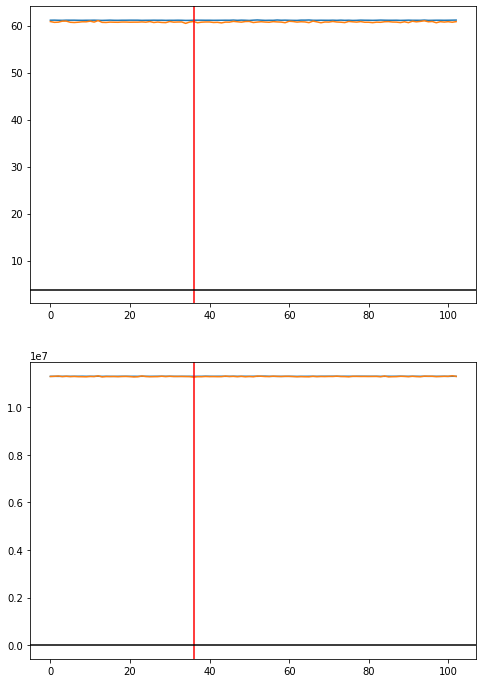

In [59]:
df_history = pd.DataFrame(history)

fig, axes = plt.subplots(2,1,figsize = (8,12))

axes[0].plot(df_history['epoch'], df_history['train_loss'])
axes[0].plot(df_history['epoch'], df_history['test_loss'])
axes[0].axvline(x = check_epoch, ymin = 0, ymax = df_history['test_loss'].max(), color = 'r')
axes[0].axhline(y = default_loss, xmin = 0, xmax = df_history['epoch'].max(), color = 'k')

axes[1].plot(df_history['epoch'], df_history['train_meas'])
axes[1].plot(df_history['epoch'], df_history['test_meas'])
axes[1].axvline(x = check_epoch, ymin = 0, ymax = df_history['test_meas'].max(), color = 'r')
axes[1].axhline(y = default_meas, xmin = 0, xmax = df_history['epoch'].max(), color = 'k')

In [ ]:
del X_train, X_test, y_train, y_test

# Submission

In [ ]:
df_test = pd.read_pickle(str(data_dir / "gsdc_test.pkl.gzip"))

print(df_test.shape)
df_test.head()

In [ ]:
model.load_state_dict(torch.load(checkpoint_path))
torch.save(model.state_dict(), model_path)

In [ ]:
# Load submission sample
submission = pd.read_csv(str(data_dir / "sample_submission.csv"))
print(submission.shape)

In [ ]:
model = SimpleNetwork(X.shape[1] * X.shape[2], y.shape[1])
model = model.to(device)
model.load_state_dict(torch.load(model_path))

In [ ]:
X, _ = extract_features(df_test, train = False)

X = torch.Tensor(X)

loader_test = DataLoader(X, batch_size = batch_size, shuffle = False)

In [ ]:
model.eval()  # 신경망을 추론 모드로 전환

# 데이터로더에서 미니배치를 하나씩 꺼내 추론을 수행
predict = []
with torch.no_grad():  # 추론 과정에는 미분이 필요없음
    for data in loader_test:
        data = data.to(device)

        outputs = model(data)  # 데이터를 입력하고 출력을 계산
        predict.append(outputs)
predict = torch.cat(predict, axis = 0).to('cpu')

In [ ]:
predict.shape

In [ ]:
print(submission.shape)
submission.columns

In [ ]:
submission['latDeg'] = predict[:,1]
submission['lngDeg'] = predict[:,2]

In [ ]:
submission.to_csv(f"./models/{notebookName}/{num_files} - result.csv", index = False)
pd.DataFrame([]).to_csv(dummy_path)